In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
import import_ipynb
import notebook2script_py

importing Jupyter notebook from notebook2script_py.ipynb


In [6]:
notebook2script_py.notebook2script('_05b_early_stopping.ipynb')

In [7]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

# ConvNet

In [8]:
x_train,y_train,x_valid,y_valid = get_data()
y_train = y_train.type(torch.LongTensor)
y_valid = y_valid.type(torch.LongTensor)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [9]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [10]:
x_train , x_valid = normalize_to(x_train , x_valid)
train_ds , valid_ds = Dataset(x_train , y_train) , Dataset(x_valid , y_valid)

In [11]:
x_train.mean() , x_train.std()

(tensor(3.9162e-08), tensor(1.))

In [12]:
nh , bs = 50 , 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds , valid_ds , bs) , c)

In [13]:
#export
class Lambda(nn.Module):
    def __init__(self , func):
        super().__init__()
        self.func = func
        
    def forward(self , x):
        return self.func(x)
    
def flatten(x):
    return x.view(x.shape[0] , -1)

In [14]:
def mnist_resize(x):
    return x.view(-1 , 1 , 28 , 28)

In [15]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize) , 
        nn.Conv2d(1 , 8 , 5 , padding = 2 , stride = 2) , nn.ReLU() , #14
        nn.Conv2d(8 ,16 , 3 , padding = 1 , stride = 2) , nn.ReLU() , # 7
        nn.Conv2d(16 , 32 , 3 , padding = 1 , stride = 2) , nn.ReLU() , # 4
        nn.Conv2d(32 , 32 , 3 , padding = 1 , stride = 2) , nn.ReLU() , # 2)
        nn.AdaptiveAvgPool2d(1) ,
        Lambda(flatten) ,
        nn.Linear(32 , data.c)
    )

In [16]:
model = get_cnn_model(data)

In [17]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
cbfs = [Recorder , partial(AvgStatsCallback , accuracy)]

In [19]:
opt = optim.SGD(model.parameters() , lr = 0.4)
learn = Learner(model , opt , loss_func , data)
run = Runner(cb_funcs = cbfs)

In [20]:
%time run.fit(1 , learn)

train: [1.936725, tensor(0.3300)]
valid: [0.609474755859375, tensor(0.8055)]
CPU times: user 8 s, sys: 691 ms, total: 8.7 s
Wall time: 4.72 s


# CUDA

In [21]:
# Somewhat more flexible way
device = torch.device('cuda' , 0)

In [22]:
class CudaCallback(Callback):
    def __init__(self , device):
        self.device = device
        
    def begin_fit(self):
        self.model.to(self.device)
        
    def begin_batch(self):
        self.run.xb , self.run.yb = self.xb.to(self.device) , self.yb.to(self.device)

In [23]:
#export
class CudaCallback(Callback):
    def begin_fit(self):
        self.model.cuda()
        
    def begin_batch(self):
        self.run.xb , self.run.yb = self.xb.cuda() , self.yb.cuda()

In [24]:
cbfs.append(CudaCallback)

In [25]:
model = get_cnn_model(data)

In [26]:
opt = optim.SGD(model.parameters() , lr = 0.4)
learn = Learner(model , opt , loss_func , data)
run = Runner(cb_funcs = cbfs)

In [27]:
%time run.fit(3 , learn)

train: [2.1190284375, tensor(0.2413, device='cuda:0')]
valid: [1.01698779296875, tensor(0.6903, device='cuda:0')]
train: [0.484871640625, tensor(0.8446, device='cuda:0')]
valid: [0.2112552490234375, tensor(0.9349, device='cuda:0')]
train: [0.1957912890625, tensor(0.9394, device='cuda:0')]
valid: [0.12654991455078124, tensor(0.9654, device='cuda:0')]
CPU times: user 6.76 s, sys: 700 ms, total: 7.46 s
Wall time: 7.42 s


# Refactor model

In [28]:
def conv2d(ni , nf , ks = 3 , stride = 2):
    return nn.Sequential(nn.Conv2d(ni , nf , ks , padding = ks // 2 , stride = stride) , nn.ReLU())

In [29]:
#export
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self , tfm):
        self.tfm = tfm
        
    def begin_batch(self):
        self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x):
        return x.view(*((-1 , ) + size))
    return _inner

In [30]:
mnist_view = view_tfm(1 , 28 , 28)
cbfs.append(partial(BatchTransformXCallback , mnist_view))

In [31]:
nfs = [8 , 16 , 32 , 32]

In [32]:
def get_cnn_layers(data , nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i] , nfs[i + 1] , 5 if i == 0 else 3)
        for i in range(len(nfs) - 1)
    ] + [nn.AdaptiveAvgPool2d(1) , Lambda(flatten) , nn.Linear(nfs[-1] , data.c)]

def get_cnn_model(data , nfs):
    return nn.Sequential(*get_cnn_layers(data , nfs))

In [33]:
#export
def get_runner(model , data , lr = 0.6 , cbs = None , opt_func = None , loss_func = F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
    
    opt = opt_func(model.parameters() , lr = lr)
    learn = Learner(model , opt , loss_func , data)
    return learn , Runner(cb_funcs = listify(cbs))

In [34]:
model = get_cnn_model(data , nfs)
learn , run = get_runner(model , data , lr = 0.4 , cbs = cbfs)

In [35]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [36]:
run.fit(3 , learn)

train: [1.7774421875, tensor(0.4064, device='cuda:0')]
valid: [0.93782578125, tensor(0.7327, device='cuda:0')]
train: [0.40231796875, tensor(0.8783, device='cuda:0')]
valid: [0.3043288330078125, tensor(0.9056, device='cuda:0')]
train: [0.19280525390625, tensor(0.9428, device='cuda:0')]
valid: [0.154276513671875, tensor(0.9536, device='cuda:0')]


# Hooks

# Manual insertion


In [37]:
class SequentialModel(nn.Module):
    def __init__(self , *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self , x):
        for i , l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
            
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [38]:
model =  SequentialModel(*get_cnn_layers(data , nfs))
learn , run = get_runner(model , data , lr = 0.9 , cbs = cbfs)

In [39]:
run.fit(2 , learn)

train: [1.93074875, tensor(0.3366, device='cuda:0')]
valid: [0.851404296875, tensor(0.7604, device='cuda:0')]
train: [0.536958203125, tensor(0.8345, device='cuda:0')]
valid: [0.1897783203125, tensor(0.9426, device='cuda:0')]


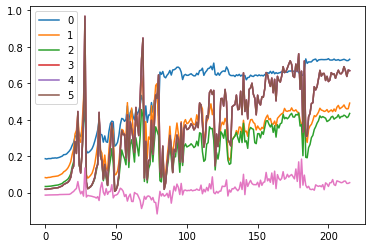

In [40]:
for l in model.act_means: 
    plt.plot(l)
plt.legend(range(6))

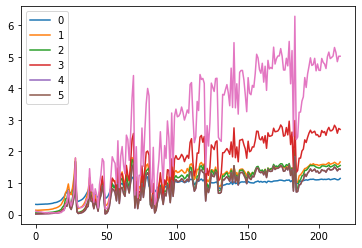

In [41]:
for l in model.act_stds: 
    plt.plot(l)
plt.legend(range(6))

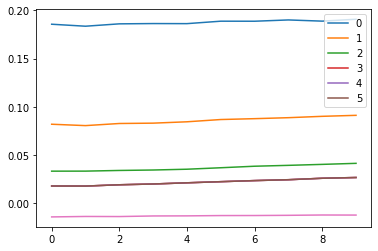

In [42]:
for l in model.act_means: 
    plt.plot(l[:10])
plt.legend(range(6))

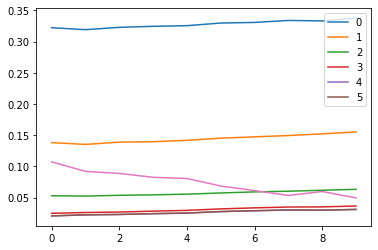

In [43]:
for l in model.act_stds: 
    plt.plot(l[:10])
plt.legend(range(6))

# Pytorch hooks

In [44]:
model = get_cnn_model(data , nfs)
learn , run = get_runner(model , data , lr = 0.5 , cbs = cbfs)

In [45]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [46]:
def append_stats(i , mod , inp , outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [47]:
for i , m in enumerate(model):
    m.register_forward_hook(partial(append_stats , i))

In [48]:
run.fit(1 , learn)

train: [2.10873875, tensor(0.2646, device='cuda:0')]
valid: [1.0868515625, tensor(0.5945, device='cuda:0')]


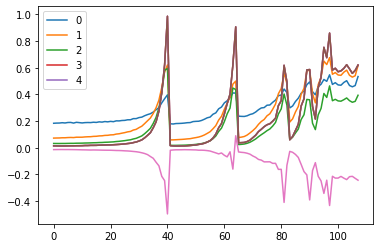

In [49]:
for o in act_means: 
    plt.plot(o)
plt.legend(range(5))

# Hook class

In [50]:
#export
def children(m):
    return list(m.children())

class Hook():
    def __init__(self , m , f):
        self.hook = m.register_forward_hook(partial(f , self))
        
    def remove(self):
        self.hook.remove()
        
    def __del__(self):
        self.remove()
        
def append_stats(hook , mod , inp , outp):
    if not hasattr(hook , 'stats'): 
        hook.stats = ([] , [])
    means , stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [51]:
model = get_cnn_model(data , nfs)
learn , run = get_runner(model , data , lr = 0.5 , cbs = cbfs)

In [52]:
hooks = [Hook(l , append_stats) for l in children(model[ : 4])]

In [53]:
run.fit(1 , learn)

train: [1.67001546875, tensor(0.4353, device='cuda:0')]
valid: [0.55457275390625, tensor(0.8166, device='cuda:0')]


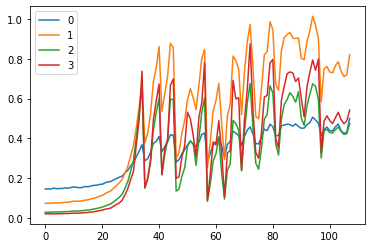

In [54]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))

# A Hooks class

In [55]:
#export
class ListContainer():
    def __init__(self , items):
        self.items = listify(items)
        
    def __getitem__(self , idx):
        if isinstance(idx , (int,slice)): 
            return self.items[idx]
        if isinstance(idx , bool):
            assert len(idx) == len(self) # bool mask
            return [o for m , o in zip(idx , self.items) if m]
        return [self.items[i] for i in idx]
    
    def __len__(self):
        return len(self.items)
    
    def __iter__(self):
        return iter(self.items)
    
    def __setitem__(self , i , o):
        self.items[i] = o
        
    def __delitem__(self , i):
        del(self.items[i])
        
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [56]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [57]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [58]:
t = ListContainer(range(10))
t[[1 , 2]] , t[[False] * 8 + [True , False]]

([1, 2], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [59]:
#export
from torch.nn import init

class Hooks(ListContainer):
    
    def __init__(self , ms , f):
        super().__init__([Hook(m , f) for m in ms])
        
    def __enter__(self , *args):
        return self
    
    def __exit__(self , *args):
        self.remove()
        
    def _del__(self):
        self.remove()
        
    def __delitem__(self , i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self:
            h.remove()

In [60]:
model = get_cnn_model(data , nfs).cuda()
learn , run = get_runner(model , data , lr = 0.9 , cbs = cbfs)

In [61]:
hooks = Hooks(model , append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f7440046c10>, <__main__.Hook object at 0x7f7440046fd0>, <__main__.Hook object at 0x7f7440046f10>, <__main__.Hook object at 0x7f742fd896d0>, <__main__.Hook object at 0x7f742fd891d0>, <__main__.Hook object at 0x7f742fd89b10>, <__main__.Hook object at 0x7f742fd89090>]

In [62]:
hooks.remove()

In [63]:
x , y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [64]:
x.mean() , x.std()

(tensor(-0.0002, device='cuda:0'), tensor(1.0008, device='cuda:0'))

In [65]:
p = model[0](x)
p.mean() , p.std()

(tensor(0.1617, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3391, device='cuda:0', grad_fn=<StdBackward0>))

In [66]:
for l in model:
    if isinstance(l , nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [67]:
p = model[0](x)
p.mean() , p.std()

(tensor(0.4463, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8150, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.95918953125, tensor(0.3346, device='cuda:0')]
valid: [0.91586806640625, tensor(0.6994, device='cuda:0')]
train: [0.4488473828125, tensor(0.8622, device='cuda:0')]
valid: [0.292231298828125, tensor(0.9140, device='cuda:0')]


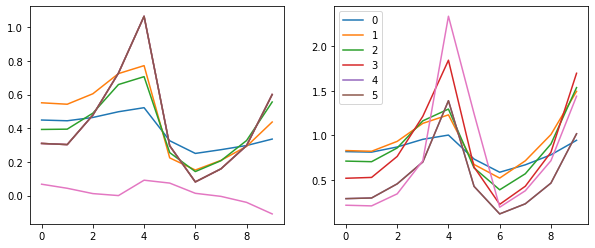

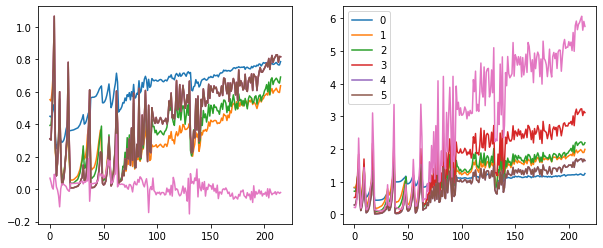

In [68]:
with Hooks(model , append_stats) as hooks:
    run.fit(2 , learn)
    fig , (ax0 , ax1) = plt.subplots(1 , 2 , figsize = (10 , 4))
    for h in hooks:
        ms , ss = h.stats
        ax0.plot(ms[ : 10])
        ax1.plot(ss[ : 10])
    plt.legend(range(6));

    fig , (ax0 , ax1) = plt.subplots(1 , 2 , figsize = (10 , 4))
    for h in hooks:
        ms , ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

**Other statistics**

In [69]:
def append_stats(hook , mod , inp , outp):
    if not hasattr(hook , 'stats'):
        hook.stats = ([] , [] , [])
    means , stds , hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10))

In [70]:
model = get_cnn_model(data , nfs).cuda()
learn , run = get_runner(model , data , lr = 0.9 , cbs = cbfs)

In [71]:
for l in model:
    if isinstance(l , nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [72]:
with Hooks(model , append_stats) as hooks: 
    run.fit(1 , learn)

train: [1.6177284375, tensor(0.4708, device='cuda:0')]
valid: [0.684369873046875, tensor(0.7948, device='cuda:0')]


In [73]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): 
    return torch.stack(h.stats[2]).t().float().log1p()

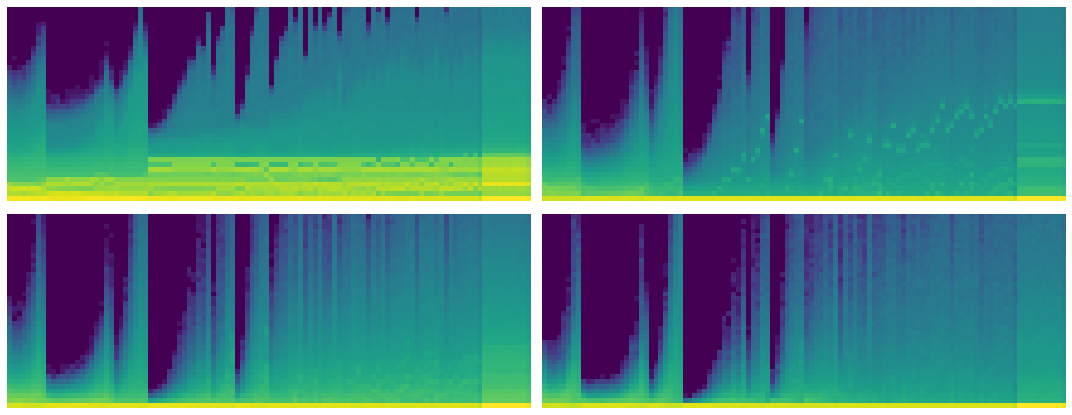

In [74]:
fig , axes = plt.subplots(2 , 2 , figsize = (15 , 6))
for ax , h in zip(axes.flatten() , hooks[ : 4]):
    ax.imshow(get_hist(h) , origin = 'lower')
    ax.axis('off')
plt.tight_layout()

In [75]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[ : 2].sum(0) / h1.sum(0)

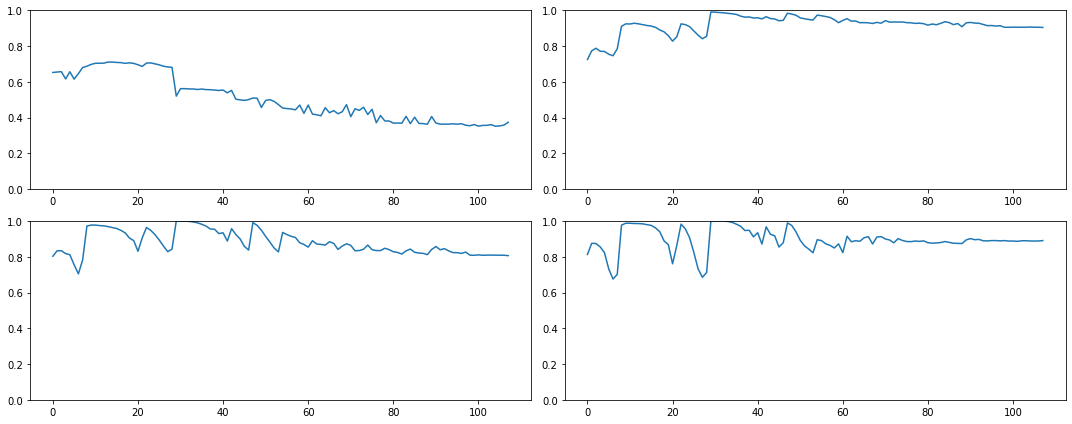

In [76]:
fig , axes = plt.subplots(2 , 2 , figsize = (15 , 6))
for ax , h in zip(axes.flatten() , hooks[ : 4]):
    ax.plot(get_min(h))
    ax.set_ylim(0 , 1)
plt.tight_layout()

Generalized ReLU

In [77]:
#export
def get_cnn_layers(data , nfs , layer , **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i] , nfs[i + 1] , 5 if i == 0 else 3 , **kwargs)
            for i in range(len(nfs) - 1)] + [
        nn.AdaptiveAvgPool2d(1) , Lambda(flatten) , nn.Linear(nfs[-1] , data.c)]

def conv_layer(ni , nf , ks = 3 , stride = 2 , **kwargs):
    return nn.Sequential(nn.Conv2d(ni , nf , ks , padding = ks // 2 , stride = stride) , GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self , leak = None , sub = None , maxv = None):
        super().__init__()
        self.leak , self.sub , self.maxv = leak , sub , maxv

    def forward(self , x):
        x = F.leaky_relu(x , self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x

def init_cnn(m , uniform = False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l , nn.Sequential):
            f(l[0].weight , a = 0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data , nfs , layer , **kwargs):
    return nn.Sequential(*get_cnn_layers(data , nfs , layer , **kwargs))

In [78]:
def append_stats(hook , mod , inp , outp):
    if not hasattr(hook , 'stats'): 
        hook.stats = ([] , [] , [])
    means , stds , hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40 , -7 , 7))

In [79]:
model = get_cnn_model(data , nfs , conv_layer , leak = 0.1 , sub = 0.4 , maxv = 6.)
init_cnn(model)
learn , run = get_runner(model , data , lr = 0.9 , cbs = cbfs)

train: [0.494682578125, tensor(0.8402, device='cuda:0')]
valid: [0.154128564453125, tensor(0.9506, device='cuda:0')]


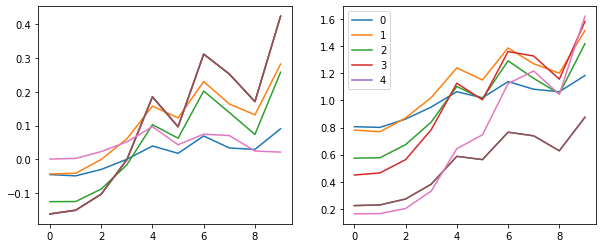

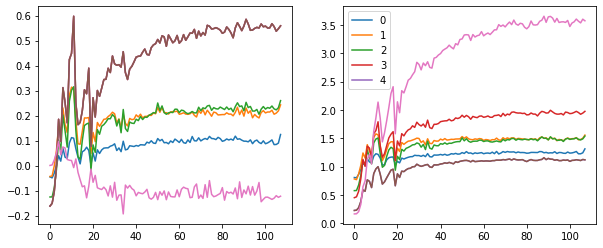

In [80]:
with Hooks(model , append_stats) as hooks:
    run.fit(1 , learn)
    fig,(ax0 , ax1) = plt.subplots(1 , 2 , figsize = (10 , 4))
    for h in hooks:
        ms , ss , hi = h.stats
        ax0.plot(ms[ : 10])
        ax1.plot(ss[ : 10])
        h.remove()
    plt.legend(range(5));
    
    fig , (ax0 , ax1) = plt.subplots(1 , 2 , figsize = (10 , 4))
    for h in hooks:
        ms , ss , hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

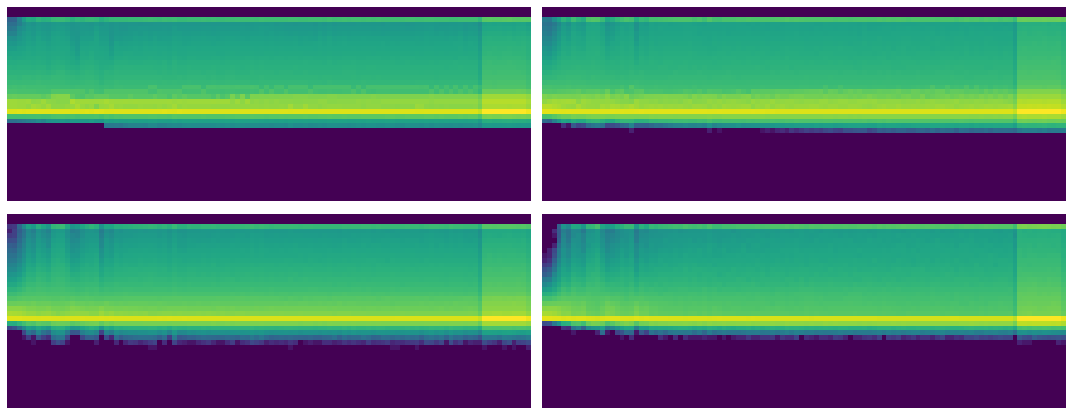

In [81]:
fig , axes = plt.subplots(2 , 2 , figsize = (15 , 6))
for ax , h in zip(axes.flatten(), hooks[ : 4]):
    ax.imshow(get_hist(h) , origin = 'lower')
    ax.axis('off')
plt.tight_layout()

In [82]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19 : 22].sum(0) / h1.sum(0)

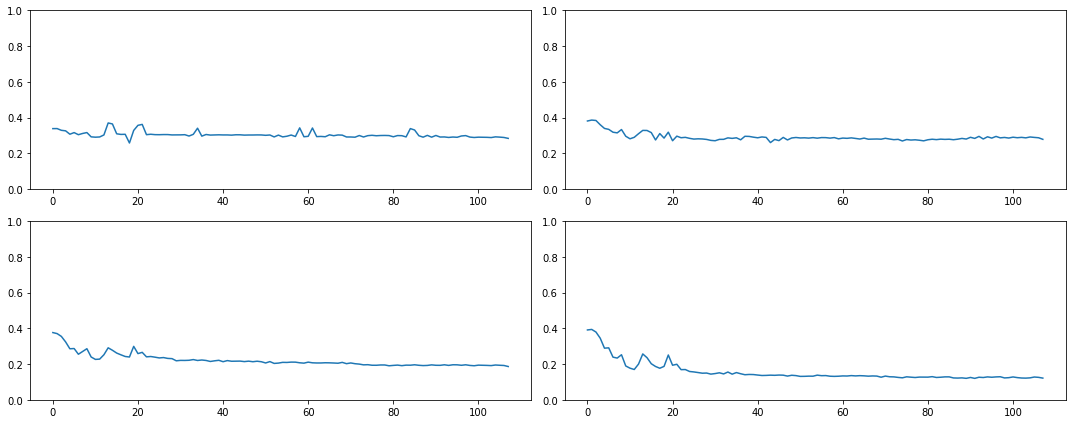

In [83]:
fig , axes = plt.subplots(2 , 2 , figsize = (15 , 6))
for ax , h in zip(axes.flatten() , hooks[ : 4]):
    ax.plot(get_min(h))
    ax.set_ylim(0 , 1)
plt.tight_layout()

In [84]:
#export
def get_learn_run(nfs , data , lr , layer , cbs = None , opt_func = None , uniform = False , **kwargs):
    model = get_cnn_model(data , nfs , layer , **kwargs)
    init_cnn(model , uniform = uniform)
    return get_runner(model , data , lr = lr , cbs = cbs , opt_func = opt_func)

In [85]:
sched = combine_scheds([0.5 , 0.5] , [sched_cos(0.2 , 1.) , sched_cos(1. , 0.1)]) 

In [86]:
learn,run = get_learn_run(nfs , data , 1. , conv_layer , cbs = cbfs + [partial(ParamScheduler , 'lr' , sched)])

In [87]:
run.fit(8 , learn)

train: [1.254359765625, tensor(0.6119, device='cuda:0')]
valid: [0.37673759765625, tensor(0.8924, device='cuda:0')]
train: [0.31985091796875, tensor(0.9041, device='cuda:0')]
valid: [0.19463076171875, tensor(0.9415, device='cuda:0')]
train: [0.3331341015625, tensor(0.9007, device='cuda:0')]
valid: [0.15732401123046874, tensor(0.9536, device='cuda:0')]
train: [0.129133564453125, tensor(0.9592, device='cuda:0')]
valid: [0.114462353515625, tensor(0.9635, device='cuda:0')]
train: [0.08317533203125, tensor(0.9741, device='cuda:0')]
valid: [0.07481353149414062, tensor(0.9783, device='cuda:0')]
train: [0.0632828369140625, tensor(0.9800, device='cuda:0')]
valid: [0.06931317138671875, tensor(0.9793, device='cuda:0')]
train: [0.0467503857421875, tensor(0.9857, device='cuda:0')]
valid: [0.0638719970703125, tensor(0.9811, device='cuda:0')]
train: [0.038495546875, tensor(0.9882, device='cuda:0')]
valid: [0.06544819946289063, tensor(0.9811, device='cuda:0')]


In [88]:
learn , run = get_learn_run(nfs , data , 1. , conv_layer , uniform = True , cbs = cbfs + [partial(ParamScheduler , 'lr' , sched)])

In [89]:
run.fit(8 , learn)

train: [1.040961640625, tensor(0.6797, device='cuda:0')]
valid: [0.297702294921875, tensor(0.9130, device='cuda:0')]
train: [0.397309375, tensor(0.8798, device='cuda:0')]
valid: [0.1920876220703125, tensor(0.9429, device='cuda:0')]
train: [0.370046875, tensor(0.8890, device='cuda:0')]
valid: [0.2005076416015625, tensor(0.9394, device='cuda:0')]
train: [0.149102060546875, tensor(0.9549, device='cuda:0')]
valid: [0.1070606201171875, tensor(0.9691, device='cuda:0')]
train: [0.110377822265625, tensor(0.9670, device='cuda:0')]
valid: [0.09201837768554688, tensor(0.9744, device='cuda:0')]
train: [0.066819619140625, tensor(0.9787, device='cuda:0')]
valid: [0.0812439453125, tensor(0.9758, device='cuda:0')]
train: [0.0495132177734375, tensor(0.9846, device='cuda:0')]
valid: [0.0705835693359375, tensor(0.9800, device='cuda:0')]
train: [0.0412652685546875, tensor(0.9871, device='cuda:0')]
valid: [0.06717036743164062, tensor(0.9810, device='cuda:0')]


In [90]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [91]:
nb_auto_export()

<IPython.core.display.Javascript object>

# Reference for this notebook

In [1]:
#https://github.com/fastai/course-v3/blob/master/nbs/dl2/06_cuda_cnn_hooks_init.ipynb